# Problem Statement

This project seeks to identify cancerous images from the PCam dataset.

# Imports

In [ ]:
from google.colab import files
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tifffile import imread
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.ticker as ticker
from tensorflow.keras.applications import ResNet50, InceptionV3

# Loading Data

In [ ]:
files.upload()

In [7]:
!ls -lh

total 6.4G
-rw-r--r-- 1 root root 6.4G Dec 12  2019 histopathologic-cancer-detection.zip
-rw-r--r-- 1 root root   65 May 24 13:38 kaggle.json
drwxr-xr-x 1 root root 4.0K May 14 13:38 sample_data


In [8]:
!unzip -q histopathologic-cancer-detection.zip

In [9]:
!ls -lh

total 6.4G
-rw-r--r-- 1 root root 6.4G Dec 12  2019 histopathologic-cancer-detection.zip
-rw-r--r-- 1 root root   65 May 24 13:38 kaggle.json
drwxr-xr-x 1 root root 4.0K May 14 13:38 sample_data
-rw-r--r-- 1 root root 2.4M Dec 12  2019 sample_submission.csv
drwxr-xr-x 2 root root 4.2M May 24 13:39 test
drwxr-xr-x 2 root root  16M May 24 13:41 train
-rw-r--r-- 1 root root 9.1M Dec 12  2019 train_labels.csv


In [10]:
!ls train | head

00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif
000020de2aa6193f4c160e398a8edea95b1da598.tif
00004aab08381d25d315384d646f5ce413ea24b1.tif
0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif
0000da768d06b879e5754c43e2298ce48726f722.tif
0000f8a4da4c286eee5cf1b0d2ab82f979989f7b.tif
00010f78ea8f878117500c445a658e5857f4e304.tif
00011545a495817817c6943583b294c900a137b8.tif
000126ec42770c7568204e2f6e07eb9a07d5e121.tif
00014e39b5df5f80df56f18a0a049d1cc6de430a.tif


In [11]:
!ls test | head

00006537328c33e284c973d7b39d340809f7271b.tif
0000ec92553fda4ce39889f9226ace43cae3364e.tif
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
000270442cc15af719583a8172c87cd2bd9c7746.tif
000309e669fa3b18fb0ed6a253a2850cce751a95.tif
000360e0d8358db520b5c7564ac70c5706a0beb0.tif
00040095a4a671280aeb66cb0c9231e6216633b5.tif
000698b7df308d75ec9559ef473a588c513a68aa.tif
0006e1af5670323331d09880924381d67d79eda0.tif


# Data Inspection & Description

The downloaded data consists of four groupings of data:
- 220,025 .tif images in the training group
- 57,458 .tif images in the testing group
- A csv of the training images with 2 fields:
  - 'id': a string field representing the image filename with the .tif extension removed.
  - 'label': an integer of either 0 (no cancer) or 1 (cancer)
- A csv of a sample submission that consists of the 57,458 images from the testing group and their predicted labels of 0 or 1. This is to be used as the template for the formatting needed for submission.

In [12]:
num_train_images = len(os.listdir("train"))
num_test_images = len(os.listdir("test"))

print("Training images:", num_train_images)
print("Testing images:", num_test_images)

Training images: 220025
Testing images: 57458


In [13]:
df_train_labels = pd.read_csv("train_labels.csv")
print("Training labels shape:", df_train_labels.shape)
print("Columns:", df_train_labels.columns.tolist())
df_train_labels.head()

Training labels shape: (220025, 2)
Columns: ['id', 'label']


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [14]:
sample_submission = pd.read_csv("sample_submission.csv")
print("Sample submission shape:", sample_submission.shape)
print("Columns:", sample_submission.columns.tolist())
sample_submission.head()

Sample submission shape: (57458, 2)
Columns: ['id', 'label']


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


# EDA

During this process we will:
- check for duplicates in the image data
- check for missing values
- check for class imbalance in the labels
- check for consistent image sizes
- look at a sample image



### Duplicate Check

In [15]:
len(df_train_labels['id'].unique())


220025

There are 220,025 unique ids, indicating that no duplicates are present in the data.

### Missing Values Check

In [16]:
df_train_labels['id'].isnull().sum()


np.int64(0)

In [17]:
df_train_labels['label'].isnull().sum()


np.int64(0)

There are no missing values in the dataset.

### Class Imbalance Check

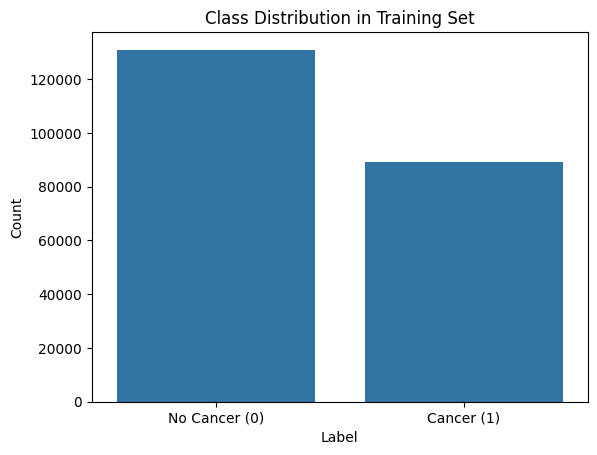

In [18]:
sns.countplot(x ='label', data = df_train_labels)

plt.title("Class Distribution in Training Set")
plt.xticks([0, 1], ["No Cancer (0)", "Cancer (1)"])
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [19]:
percentages = df_train_labels['label'].value_counts(normalize=True) * 100
print(percentages)

label
0    59.496875
1    40.503125
Name: proportion, dtype: float64


The data set consists of 59.5% images labeled as non-cancer and 40.5% images labeled as cancer. While this is not a severe imbalance it is something to keep in mind during the model training and evaluation.

### Image Size

In [20]:
sample_ids = df_train_labels['id'].sample(100)
sizes = [cv2.imread(f"train/{img_id}.tif").shape for img_id in sample_ids]
print(len(unique_sizes := set(sizes)))

1


In [21]:
print(sizes)

[(96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3), (96, 96, 3)

Based on a sample of 100 images, the sizes of the images are all the same at 96x96x3.

### Sample Images

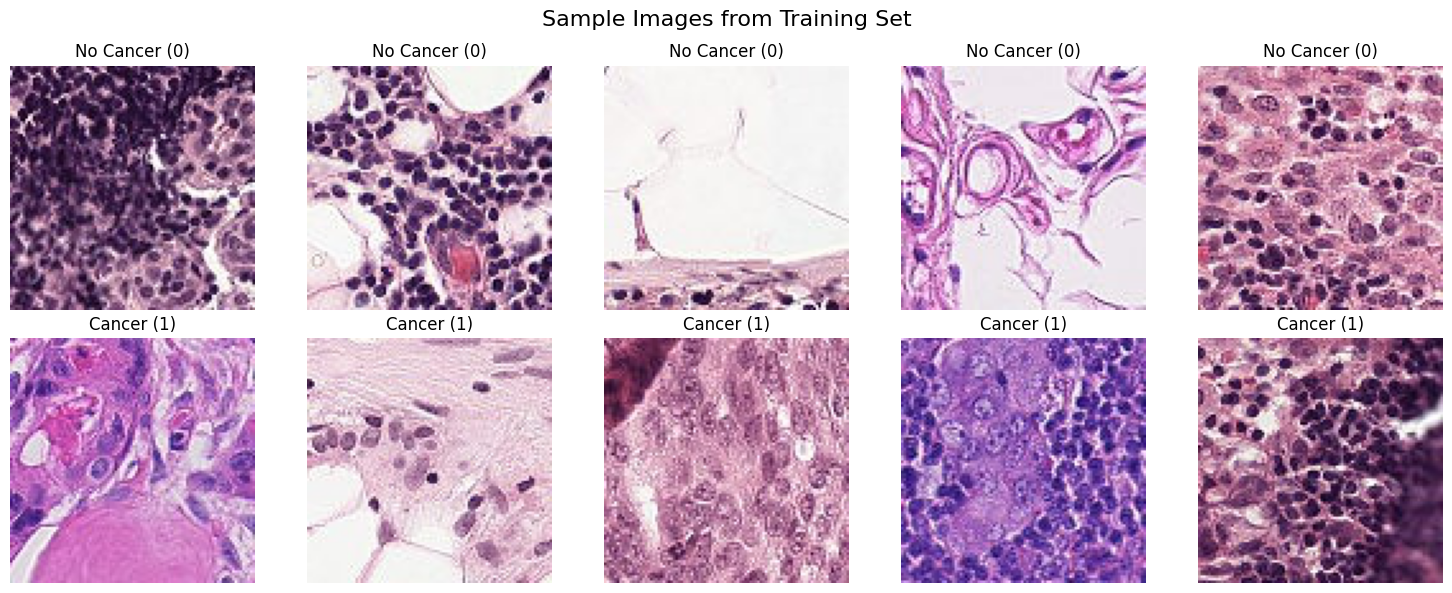

In [22]:
sample_cancer = df_train_labels[df_train_labels['label'] == 1].sample(5)['id'].values
sample_no_cancer = df_train_labels[df_train_labels['label'] == 0].sample(5)['id'].values

fig, axes = plt.subplots(2, 5, figsize=(15, 6))


for i, img_id in enumerate(sample_no_cancer):
    image = imread(f"train/{img_id}.tif")
    axes[0, i].imshow(image)
    axes[0, i].set_title("No Cancer (0)")
    axes[0, i].axis('off')

for i, img_id in enumerate(sample_cancer):
    image = imread(f"train/{img_id}.tif")
    axes[1, i].imshow(image)
    axes[1, i].set_title("Cancer (1)")
    axes[1, i].axis('off')

plt.suptitle("Sample Images from Training Set", fontsize=16)
plt.tight_layout()
plt.show()

Looking at the samples, there aren't any obvious or straightforward visual differences. Let's look at an "average" no cancer vs an "average" cancer image to see if these results are more telling.

### Comparing an average image

In [23]:
def compute_average_image(df_subset, n=500):
    image_ids = df_subset.sample(n)['id'].values
    images = []

    for img_id in image_ids:
        img = imread(f'train/{img_id}.tif')
        images.append(img.astype(np.float32))

    return np.mean(images, axis=0).astype(np.uint8)


In [24]:
avg_no_cancer = compute_average_image(df_train_labels[df_train_labels['label'] == 0])
avg_cancer = compute_average_image(df_train_labels[df_train_labels['label'] == 1])

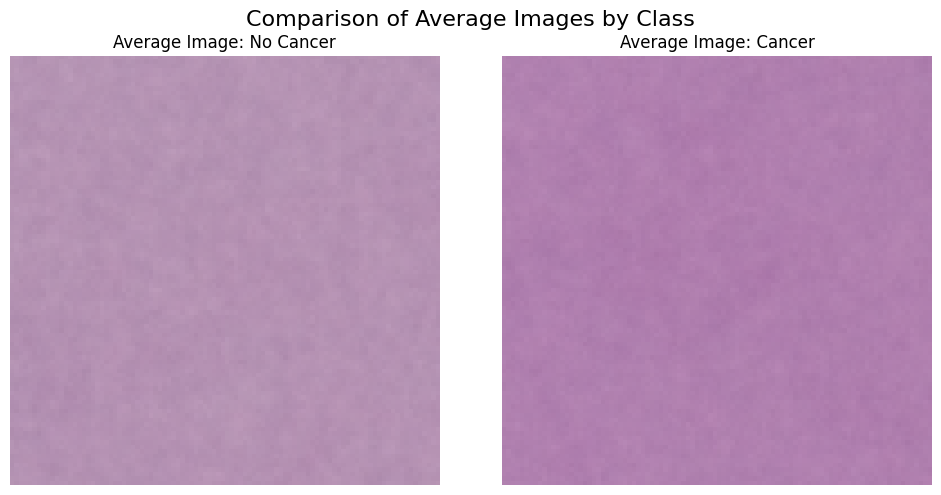

In [25]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(avg_no_cancer)
plt.title("Average Image: No Cancer")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(avg_cancer)
plt.title("Average Image: Cancer")
plt.axis('off')

plt.suptitle("Comparison of Average Images by Class", fontsize=16)
plt.tight_layout()
plt.show()

The average images don't reveal strong visual differences, but cancerous images appear slightly darker on average than non-cancerous images.

### EDA Summary
Through the EDA process we learned:
- the dataset is clean
  - no duplicates
  - no missing values
- there is a slight class imbalance
  - 59.5% of the images labeled as non-cancer
  - 40.5% of the images labeled as cancer
- the image size is consistent across images
  - 96x96x3
- the average image for the cancer group appears darker than the average image for the non-cancer group



# Model Building

We will be using the ResNet and Inception architectures and comparing their performance. These models were chosen over VGGNet because both ResNet and Inception have been shown to outperform VGGNet in terms of accuracy and computational efficiency, particularly on large and complex datasets.

Additionally, EDA revealed differences between cancerous and non-cancerous images are often subtle. ResNet and Inception are better equipped to model these subtle differences.

### Preprocessing

We will first split the training data into a training and validation set so that we are able to holdout data and see the accuracy of the results.

In [26]:
SEED = 42
img_height, img_width = 224, 224
batch_size = 32
num_classes = 2
epochs = 10

In [27]:
train_df, val_df = train_test_split(df_train_labels, test_size=0.2, stratify=df_train_labels['label'], random_state=SEED)

Next we will augment the training data to help prevent overfitting. We also will rescale the images in both the training data and validation set.

In [28]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)


Now we will generate batches of the augmented data and load the pre-trained model.

In [29]:
train_df['filename'] = train_df['id'] + '.tif'
val_df['filename'] = val_df['id'] + '.tif'

In [30]:
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

In [31]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='train',
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed = SEED
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    directory = 'train',
    x_col = 'filename',
    y_col = 'label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


### Build the ResNet50 Model

We start with global average pooling, 128 neurons, and a 50% dropout rate to help prevent overfitting. In addition, we will be using the 'adam' optimizer per the suggestion in the course.

In [36]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [37]:
for layer in base_model.layers:
    layer.trainable = False

In [38]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [39]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[AUC(name='auc')]
)

In [40]:
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint, early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - auc: 0.7326 - loss: 0.5896
Epoch 1: val_auc improved from -inf to 0.83262, saving model to best_model.h5


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1801s 325ms/step - auc: 0.7327 - loss: 0.5896 - val_auc: 0.8326 - val_loss: 0.5089
Epoch 2/10
   1/5500 ━━━━━━━━━━━━━━━━━━━━ 6:20 69ms/step - auc: 0.7523 - loss: 0.5135

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_auc did not improve from 0.83262
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 107s 19ms/step - auc: 0.7523 - loss: 0.5135 - val_auc: 0.8324 - val_loss: 0.5094
Epoch 3/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - auc: 0.7942 - loss: 0.5426
Epoch 3: val_auc improved from 0.83262 to 0.83635, saving model to best_model.h5


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1777s 323ms/step - auc: 0.7942 - loss: 0.5426 - val_auc: 0.8364 - val_loss: 0.4973
Epoch 4/10
   1/5500 ━━━━━━━━━━━━━━━━━━━━ 6:20 69ms/step - auc: 0.7338 - loss: 0.5408
Epoch 4: val_auc improved from 0.83635 to 0.83710, saving model to best_model.h5


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 107s 20ms/step - auc: 0.7338 - loss: 0.5408 - val_auc: 0.8371 - val_loss: 0.4965
Epoch 5/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - auc: 0.7980 - loss: 0.5397
Epoch 5: val_auc improved from 0.83710 to 0.84085, saving model to best_model.h5


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1752s 319ms/step - auc: 0.7980 - loss: 0.5397 - val_auc: 0.8408 - val_loss: 0.4972
Epoch 6/10
   1/5500 ━━━━━━━━━━━━━━━━━━━━ 6:16 68ms/step - auc: 0.8631 - loss: 0.4892
Epoch 6: val_auc did not improve from 0.84085
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 106s 19ms/step - auc: 0.8631 - loss: 0.4892 - val_auc: 0.8392 - val_loss: 0.4976
Epoch 7/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - auc: 0.8046 - loss: 0.5354
Epoch 7: val_auc did not improve from 0.84085
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1739s 316ms/step - auc: 0.8046 - loss: 0.5354 - val_auc: 0.8385 - val_loss: 0.5083
Epoch 8/10
   1/5500 ━━━━━━━━━━━━━━━━━━━━ 6:45 74ms/step - auc: 0.8542 - loss: 0.4862
Epoch 8: val_auc did not improve from 0.84085
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 106s 19ms/step - auc: 0.8542 - loss: 0.4862 - val_auc: 0.8399 - val_loss: 0.5078
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 5.


Plot the results

In [42]:
train_auc = history.history['auc']
val_auc = history.history['val_auc']
epochs_range = range(1, len(train_auc) + 1)

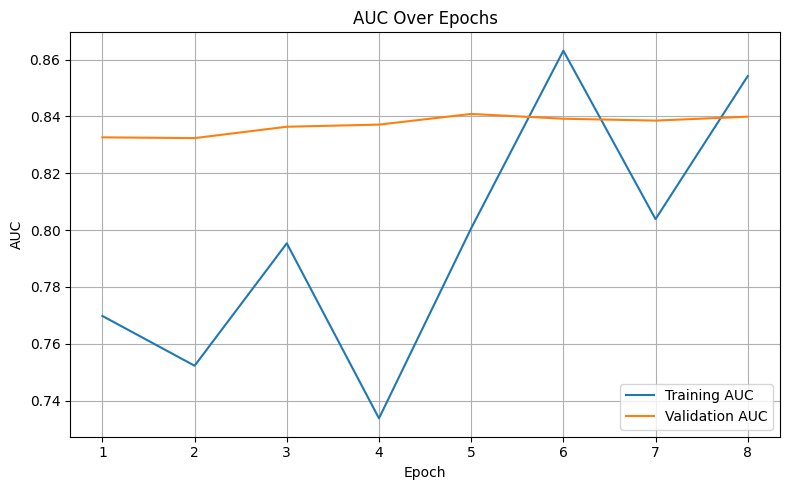

In [43]:
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.title('AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

The validation AUC remains relatively stable through out, which suggests the model is generalizing well. However, the training AUC continues to increase indicating the model is still actively learning. We are going to do some fine tuning to see if we can further improve the results.

### Tuning

During this process we are going to unfreeze layers of the base ResNet model and lower the learning rate. We will unfreeze the last 20 layers of the base ResNet model with the idea that by doing so the model will be able to better adapt to this particular dataset and improve performance. We are going to lower the learning rate with the goal of improved accuracy and generalization.

Unfreeze layers

In [45]:
for layer in base_model.layers[-20:]:
    layer.trainable = True

Recompile with a lower learning rate

In [46]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[AUC(name='auc')]
)

In [47]:
early_stop = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

history_finetune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/5
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - auc: 0.8040 - loss: 0.9564
Epoch 1: val_auc improved from 0.84085 to 0.87323, saving model to best_model.h5


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1761s 317ms/step - auc: 0.8041 - loss: 0.9563 - val_auc: 0.8732 - val_loss: 0.4445
Epoch 2/5
   1/5500 ━━━━━━━━━━━━━━━━━━━━ 8:51 97ms/step - auc: 0.8882 - loss: 0.4545
Epoch 2: val_auc did not improve from 0.87323
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 107s 19ms/step - auc: 0.8882 - loss: 0.4545 - val_auc: 0.8731 - val_loss: 0.4442
Epoch 3/5
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - auc: 0.8563 - loss: 0.4662
Epoch 3: val_auc did not improve from 0.87323
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1744s 317ms/step - auc: 0.8563 - loss: 0.4662 - val_auc: 0.8681 - val_loss: 0.4503
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


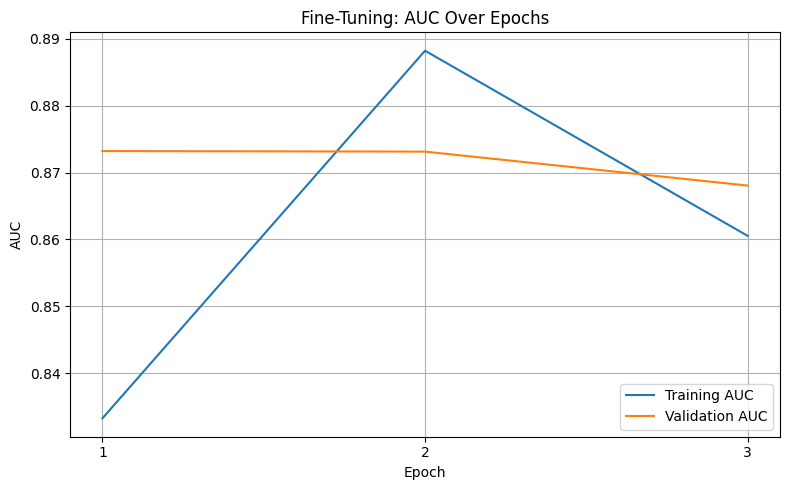

In [50]:
train_auc = history_finetune.history['auc']
val_auc = history_finetune.history['val_auc']
epochs_range = range(1, len(train_auc) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.title('Fine-Tuning: AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(loc='lower right')
plt.grid(True)

plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

### Tuning Summary

Fine tuning the top layers of ResNet50 improved the validation AUC score and did not harm stability. The model reached its peak AUC at epoch 2 for the training set. This suggests that unfreezing the final layers and reducing the learning rate enable the model to refine its feature detection for this dataset.

### Load the best model

In [52]:
model = load_model('best_model.h5')


In [43]:
test_dir = 'test'
test_filenames = os.listdir(test_dir)

test_df = pd.DataFrame({'filename': test_filenames})

In [55]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='test',
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

Found 57458 validated image filenames.


In [56]:
pred_probs = model.predict(test_generator, verbose=1)


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 148s 81ms/step


### Generate Submission File

In [61]:
test_df['id'] = test_df['filename'].str.replace('.tif', '', regex=False)


In [62]:
submission = pd.DataFrame({
    'id': test_df['id'],
    'label': pred_probs.flatten()
})

In [63]:
submission.to_csv('submission.csv', index=False)

In [64]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Submission Score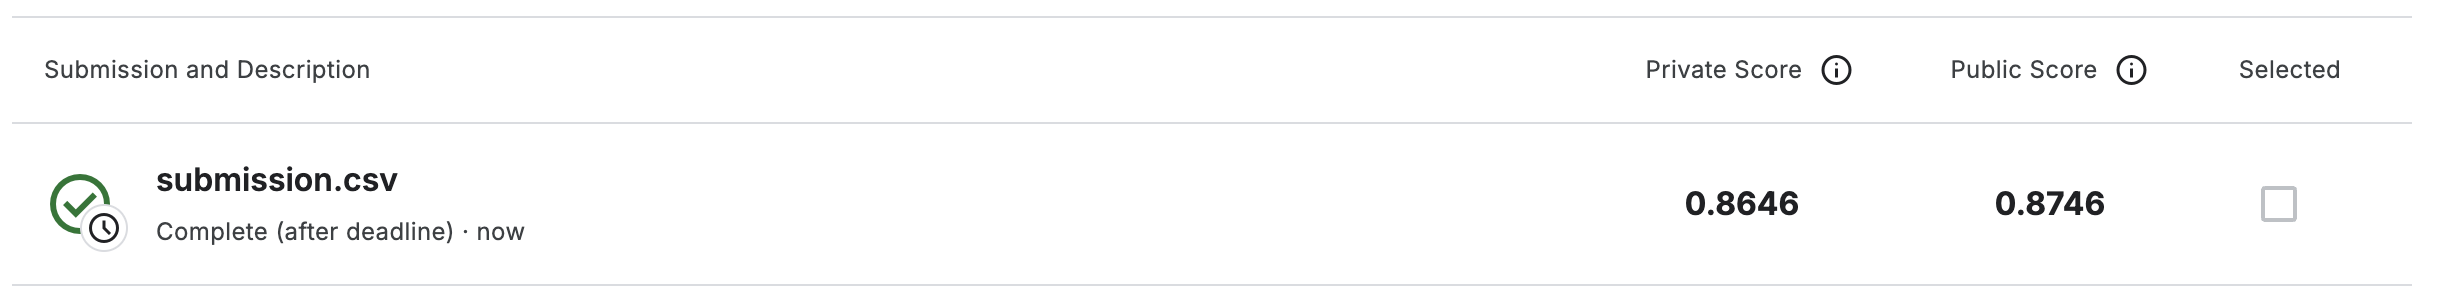

### Build the Inception Model

We are now going to build the same process with the inception model and compare the performance.

In [32]:
epochs = 10
img_height, img_width = 229, 229

Rebuild the generators with the updated size

In [33]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='train',
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=SEED
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='train',
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [34]:
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

for layer in base_model.layers:
    layer.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Add the custom classifer

In [35]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

Compile

In [36]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[AUC(name='auc')]
)

Fit the model

In [37]:
early_stop = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model_inception.h5',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

history_inception = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - auc: 0.8775 - loss: 0.4260
Epoch 1: val_auc improved from -inf to 0.92763, saving model to best_model_inception.h5


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1931s 348ms/step - auc: 0.8775 - loss: 0.4260 - val_auc: 0.9276 - val_loss: 0.3374
Epoch 2/10
   1/5500 ━━━━━━━━━━━━━━━━━━━━ 1:41 18ms/step - auc: 0.8806 - loss: 0.4050

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_auc improved from 0.92763 to 0.92767, saving model to best_model_inception.h5


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step - auc: 0.8806 - loss: 0.4050 - val_auc: 0.9277 - val_loss: 0.3371
Epoch 3/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - auc: 0.9092 - loss: 0.3717
Epoch 3: val_auc improved from 0.92767 to 0.93055, saving model to best_model_inception.h5


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1891s 344ms/step - auc: 0.9092 - loss: 0.3717 - val_auc: 0.9305 - val_loss: 0.3259
Epoch 4/10
   1/5500 ━━━━━━━━━━━━━━━━━━━━ 1:39 18ms/step - auc: 0.9130 - loss: 0.3934
Epoch 4: val_auc did not improve from 0.93055
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 53s 10ms/step - auc: 0.9130 - loss: 0.3934 - val_auc: 0.9305 - val_loss: 0.3264
Epoch 5/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - auc: 0.9140 - loss: 0.3627
Epoch 5: val_auc improved from 0.93055 to 0.93372, saving model to best_model_inception.h5


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1894s 344ms/step - auc: 0.9140 - loss: 0.3627 - val_auc: 0.9337 - val_loss: 0.3272
Epoch 6/10
   1/5500 ━━━━━━━━━━━━━━━━━━━━ 1:40 18ms/step - auc: 0.8625 - loss: 0.4530
Epoch 6: val_auc improved from 0.93372 to 0.93382, saving model to best_model_inception.h5


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step - auc: 0.8625 - loss: 0.4530 - val_auc: 0.9338 - val_loss: 0.3255
Epoch 7/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - auc: 0.9171 - loss: 0.3569
Epoch 7: val_auc improved from 0.93382 to 0.93496, saving model to best_model_inception.h5


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1895s 345ms/step - auc: 0.9171 - loss: 0.3569 - val_auc: 0.9350 - val_loss: 0.3220
Epoch 8/10
   1/5500 ━━━━━━━━━━━━━━━━━━━━ 1:38 18ms/step - auc: 0.9176 - loss: 0.3675
Epoch 8: val_auc improved from 0.93496 to 0.93506, saving model to best_model_inception.h5


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 53s 10ms/step - auc: 0.9176 - loss: 0.3675 - val_auc: 0.9351 - val_loss: 0.3217
Epoch 9/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - auc: 0.9179 - loss: 0.3551
Epoch 9: val_auc improved from 0.93506 to 0.93653, saving model to best_model_inception.h5


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1887s 343ms/step - auc: 0.9179 - loss: 0.3551 - val_auc: 0.9365 - val_loss: 0.3115
Epoch 10/10
   1/5500 ━━━━━━━━━━━━━━━━━━━━ 1:42 19ms/step - auc: 0.9757 - loss: 0.2176
Epoch 10: val_auc improved from 0.93653 to 0.93656, saving model to best_model_inception.h5


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step - auc: 0.9757 - loss: 0.2176 - val_auc: 0.9366 - val_loss: 0.3116
Restoring model weights from the end of the best epoch: 10.


In [38]:
files.download('best_model_inception.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Plot the results

In [39]:
train_auc = history_inception.history['auc']
val_auc = history_inception.history['val_auc']
epochs_range = range(1, len(train_auc) + 1)

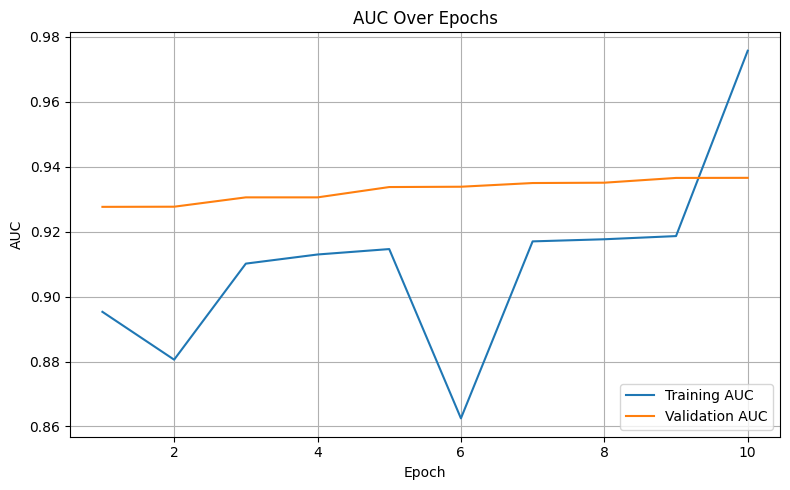

In [40]:
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.title('AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

The training AUC is continuing to increase across epochs indicating it is still actively learning. Additional fine tuning could be performed to improve performance, however since we already have a relatively good AUC in the validation set, we will load the best model and apply it to the testing data.

### Load the Best Inception Model & Appply to Testing Data

In [41]:
model_inception = load_model('best_model_inception.h5')


In [44]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen_inception = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='test',
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

Found 57458 validated image filenames.


In [45]:
pred_probs_inception = model.predict(test_gen_inception, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 79s 41ms/step


In [46]:
test_df['id'] = test_df['filename'].str.replace('.tif', '', regex=False)


### Submission File

In [47]:
submission_inception = pd.DataFrame({
    'id': test_df['id'],
    'label': pred_probs_inception.flatten()
})

In [48]:
submission_inception.to_csv('submission_inception.csv', index=False)

In [49]:
files.download('submission_inception.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Submission Results
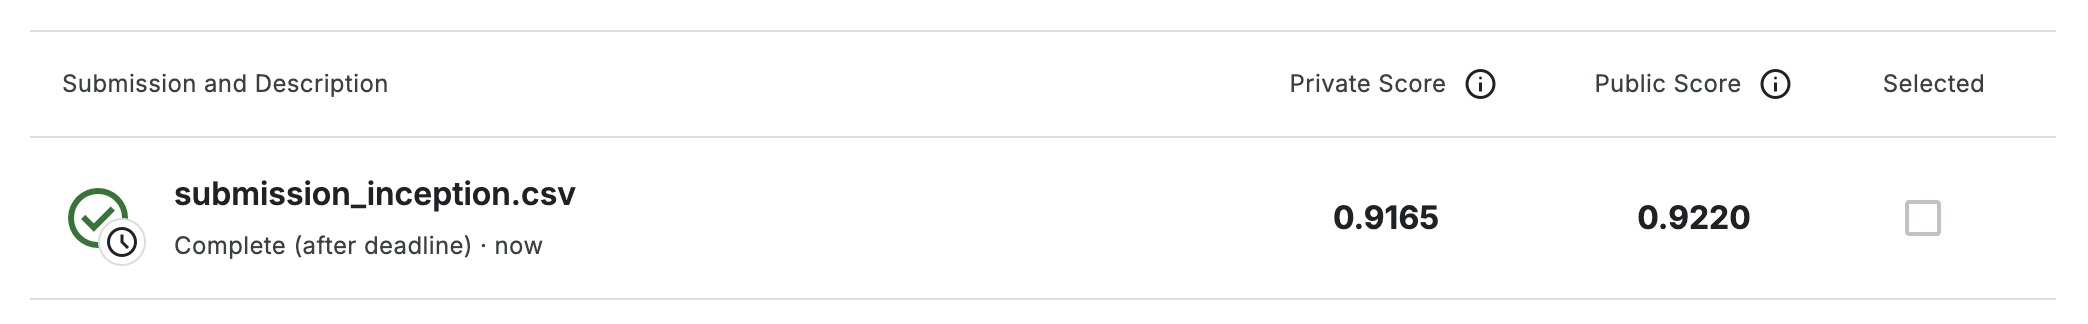

# Results & Summary

By fine-tuning the top layers and learning rate, the ResNet50 model was better able to adapt to this particular dataset of images and as a result had a better AUC score on the validation set. This tuned model was then used on the testing data and produced an AUC score of 0.8646.

We then moved into building an Inception model and began with the same parameters, except for a change in image size to better fit this particular model's expected image size. These results showed that the model was still actively learning at the end of 10 epochs, which was evidenced by the continued increase of the training data's AUC score. We could've fine tuned from here but because our validation set's AUC score was already higher than the best ResNet50 model, we chose to go ahead and run the best model on the test data and submit the results. We can see in the image below that based on the AUC score, the Inception model did outperform the RestNet50 model.

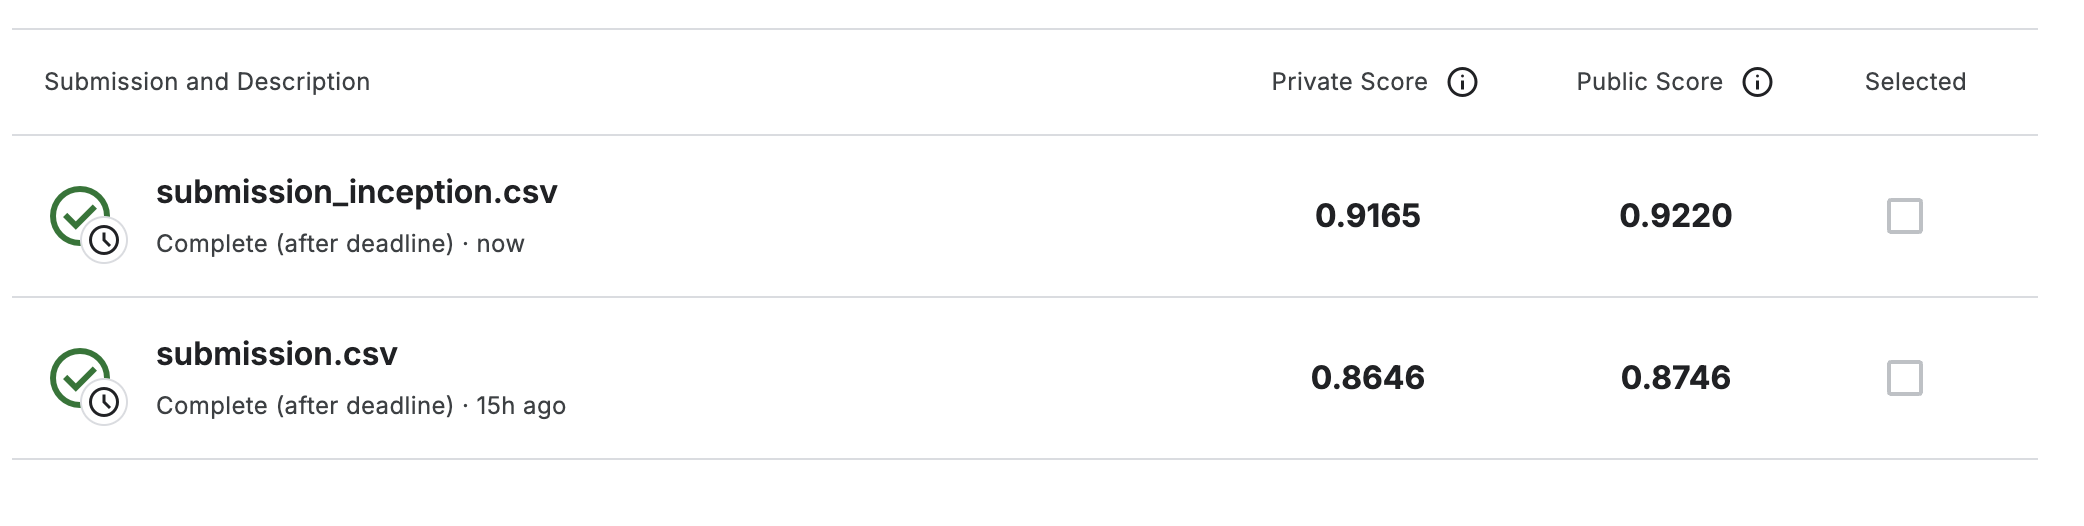

If we were to further improve on this project, we would do additional tuning on the Inception model with the goal of further increasing the AUC score.